In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit

# neural network packages
import torch
import torch.utils
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

# data processing from scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split

# to estimate the HAR model
from statsmodels.regression.linear_model import OLS
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm

# own helping code for estimation, data processing etc.
from utils.estimating import EarlyStopper, model_estimator, kfolds_fit_and_evaluate_model, single_fit_and_evaluate_model, fit_and_evaluateHAR
from utils.preprocessing import DataSet, DataSetNump, pre_process_all_data
from utils.functions import get_rv_from_yahoo, get_rv_from_data, get_tickers_in_data, print_nicely, reset_model_weights
from utils.modelbuilder import ForwardNeuralNetwork

# diebold mariano to compare the prediction accuracy of two different models
from dieboldmariano import dm_test

# ignore annoying warnings
import warnings
warnings.simplefilter("ignore")

### Process Data to Features, Targets and Divide in Training/Validation Data
- First the features are computed (previous daily/weekly/monthly volatility)
- Then the data seperated into training and validation data 

In [6]:
print(get_tickers_in_data())
print(plot_tickers_in_data())

['.AEX', '.AORD', '.BFX', '.BSESN', '.BVLG', '.BVSP', '.DJI', '.FCHI', '.FTMIB', '.FTSE', '.GDAXI', '.GSPTSE', '.HSI', '.IBEX', '.IXIC', '.KS11', '.KSE', '.MXX', '.N225', '.NSEI', '.OMXC20', '.OMXHPI', '.OMXSPI', '.OSEAX', '.RUT', '.SMSI', '.SPX', '.SSEC', '.SSMI', '.STI', '.STOXX50E']


Total of 5530 found for symbol: .SPX
Total training observations: 5208
Total validation observations: 300


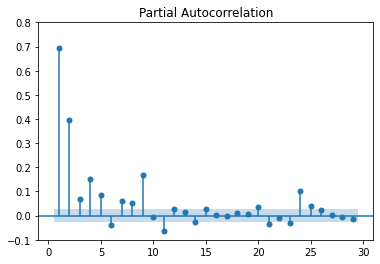

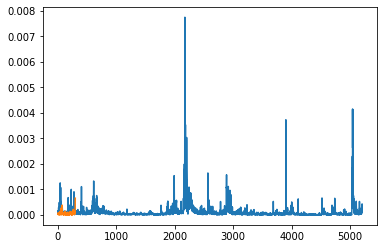

In [3]:
# fetch data through yahoo finance API, compute features, split into training and validation subsets
# ... for both NN and HAR

ticker = ".SPX"

# data = get_rv_from_yahoo(ticker)
# or use ...
data = get_rv_from_data(ticker)
n_observations = len(data)
print(f"Total of {n_observations} found for symbol: {ticker}")

# data_nn_train, data_nn_val, data_har_train, data_har_val = pre_process_all_data(data, train_size=.8)
data_nn_train, data_nn_val, data_har_train, data_har_val = pre_process_all_data(data, test_size = 300)

train_observations, test_observations = len(data_nn_train), len(data_nn_val)
print(f"Total training observations: {train_observations}")
print(f"Total validation observations: {test_observations}")

# to determine gap used in TimeSeriesSplit
plot_pacf(data_har_train.y, lags = range(1, 30))
plt.ylim(-0.1, 0.8)
plt.show()
plt.plot(data_har_train.y)
plt.plot(data_har_val.y)
plt.show()

### Model Specification of the Neural Network
Perform cross validation on a feed-forward neural network, with varying hidden layers, nodes, learning rate and epochs.
The NN is estimated using Adam optimzer and MSE loss, with a specified learning rate.

In [4]:
# PERFORM CROSS VALIDATION
model_scores = []

hidden_layers_list: tuple = ([2,],)
lr_list: tuple = (5e-4, 1e-4, 5e-5, 1e-5)
epochs_list: tuple = (1000,)
patience_list: tuple = (5,)
batch_sizes: tuple = (10,)
total_model_options: int = len(hidden_layers_list) * len(lr_list) * len(epochs_list) * len(batch_sizes) * len(patience_list)
number_of_repeated_kfolds: int = 5

# for all possible model and estimation configurations, perform kfold cross validation
counter = 0
for hidden_layers in hidden_layers_list:
    for lr in lr_list:
        for epochs in epochs_list:
            for batch_size in batch_sizes:
                for patience in patience_list:
            
                    counter += 1
                    print(f"Currently at model: {counter} / {total_model_options}", end="\r")
                    
                    avg_score_multiple_folds_list = [           
                        # fit and evaluate model through cross validation
                        kfolds_fit_and_evaluate_model(
                            input_size = data_nn_train.x_t.shape[1],
                            output_size = 1,
                            hidden_layers = hidden_layers,
                            # kfold = TimeSeriesSplit(n_splits = 10, max_train_size = None, test_size = 500, gap = 25), # the test_size = len(data) // (n_splits + 1)
                            kfold = TimeSeriesSplit(n_splits = 8, max_train_size = None, test_size = 300, gap = 25), # the test_size = len(data) // (n_splits + 1)
                            data = data_nn_train,
                            lr = lr, 
                            epochs = epochs, 
                            earlystopper = EarlyStopper(patience=patience, min_delta=0),
                            normalize_features = False,
                            batch_size = batch_size,
                        )
                        for i in range(number_of_repeated_kfolds)
                    ]
                    
                    avg_score_multiple_folds = np.average(avg_score_multiple_folds_list)
                    
                    print(f"model: hidden layers={hidden_layers} lr={lr} epochs={epochs} batch_size={batch_size} patience={patience}")
                    print(f"avg score: {avg_score_multiple_folds} list of scores: {avg_score_multiple_folds_list}")
                    
                    # store the models performance in array
                    model_scores += [(avg_score_multiple_folds, epochs, hidden_layers, lr, batch_size, patience)]
                    # model_scores += [(score_nn, epochs, hidden_layers, lr)]

# put all scores with hyperparams in a dataframe, sort on lowest MSE and show
df_scores = pd.DataFrame(data = model_scores, columns = ["avg_score", "epochs", "hidden_nodes", "lr", "batch_size", 'patience'])
df_scores = df_scores.sort_values(by="avg_score", ascending = True).reset_index(drop=True)
print(df_scores.head(10))

# store best params as variables for the final estimation beneath
epochs, hidden_layers, lr, batch_size, patience = df_scores.values[0][1:]
epochs, batch_size = int(epochs), int(batch_size)

model: hidden layers=[2] lr=0.0005 epochs=1000 batch_size=10 patience=5
avg score: 0.00017211052181664854 list of scores: [0.00027458303, 6.622821e-08, 6.62777e-05, 0.0005195007, 1.2491182e-07]
model: hidden layers=[2] lr=0.0001 epochs=1000 batch_size=10 patience=5
avg score: 0.052560389041900635 list of scores: [0.04324039, 0.017551225, 0.031789616, 0.10454547, 0.06567525]
model: hidden layers=[2] lr=5e-05 epochs=1000 batch_size=10 patience=5
avg score: 0.1164148598909378 list of scores: [0.068158016, 0.08638795, 0.084221974, 0.22946775, 0.11383861]
model: hidden layers=[2] lr=1e-05 epochs=1000 batch_size=10 patience=5
avg score: 0.14616210758686066 list of scores: [0.19646615, 0.09880683, 0.1666379, 0.09129267, 0.17760703]
   avg_score  epochs hidden_nodes       lr  batch_size  patience
0   0.000172    1000          [2]  0.00050          10         5
1   0.052560    1000          [2]  0.00010          10         5
2   0.116415    1000          [2]  0.00005          10         5
3   0

### Fit and Compare the Final Neural Network Against the HAR Model

HAR out-of-sample loss: 2.7338040720081835e-09


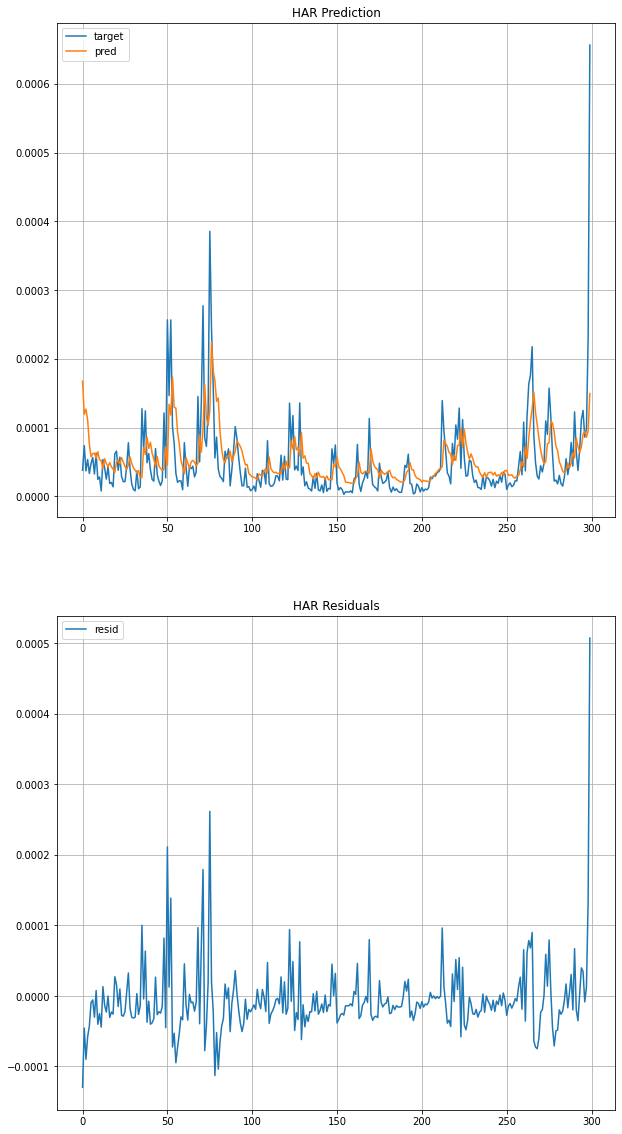

Estimating NN model ...
... with epochs=1000, hidden_layers=[2], lr=0.0005
NN out-of-sample loss: 1.209884192832078e-08


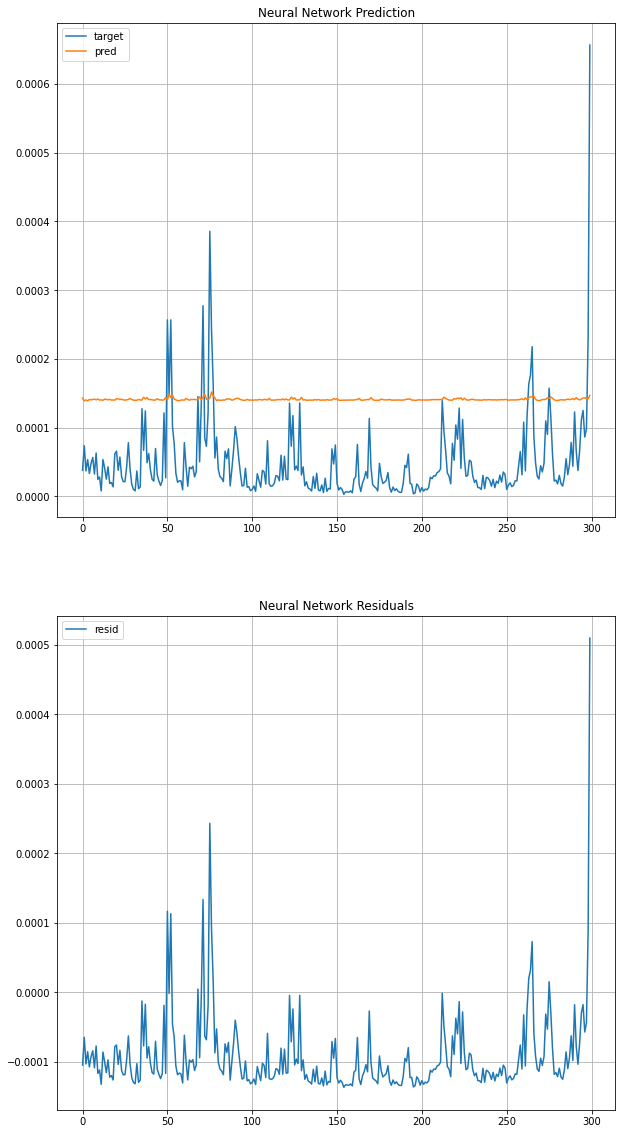

Diebold-Mariano test
H0: stat = 0, H1: stat < 0
I.e., p-val < p_crit implies NN performs significantly better
stat: 22.689707041901112 p_val: 1.0


In [5]:
normalize_features = False
use_own_config = False # !!! if you used this once after the cross validation, the custom params below 'overwrite' those from cross validation above

# sometimes we want to zoom in on specific intervals of the forecast
idx_start, idx_end = 0, 10000

# if the params are not set through cross validations above
try:
    epochs, lr, hidden_layers
    if use_own_config: raise Exception()
except Exception as e:
    print("No params from cross validation, using own params instead")
    print("Or specifically specified to use own params")
    epochs = 50
    hidden_layers = [] # zero or one with 2 nodes
    lr = 5e-5
    batch_size = 10
    patience = 3

#=========================================================================================
#===================================ESTIMATE HAR==========================================
#=========================================================================================
# the goal was to instantiate the model before passing it to the estimation function, so we can use the model here
# this does not work
HAR = OLS(np.zeros(10), np.zeros(10)) # these params are placeholders
loss, output = fit_and_evaluateHAR(
    model = HAR,
    data_train = data_har_train,
    data_test = data_har_val,
    normalize_features = False
)
har_loss = loss
har_output = output.copy().reshape(-1,)

print(f"HAR out-of-sample loss: {loss}")

plot = True
if plot:        
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (10, 20))
    axs[0].set_title("HAR Prediction")
    axs[1].set_title("HAR Residuals")
    axs[0].plot(data_har_val.y[idx_start:idx_end], label = "target")
    axs[0].plot(output[idx_start:idx_end], label = "pred")
    axs[1].plot((data_har_val.y - output)[idx_start:idx_end], label = "resid")
     
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()

#=========================================================================================
#====================================ESTIMATE NN==========================================
#=========================================================================================
print("Estimating NN model ...")
print(f"... with epochs={epochs}, hidden_layers={hidden_layers}, lr={lr}")

if False:
    def test():
        NN = ForwardNeuralNetwork(
            data_nn_train.x_t.shape[1], 
            output_size = 1, 
            hidden_layers=hidden_layers, 
            # seed=3407
            )
        loss, output = single_fit_and_evaluate_model(
            NN,
            data_train = data_nn_train,
            data_test = data_nn_val,
            lr = lr,
            epochs = epochs,
            earlystopper = EarlyStopper(patience=patience, min_delta=0),
            normalize_features = False,
            return_prediction = True,
            batch_size=batch_size
        )
        return loss
    avg_loss = [test() for i in range(10)]
    print(avg_loss)
    print(f"avg loss of multiple nn: {np.average(avg_loss)}")
    raise Exception("kappen nu")

nn_loss = float("inf")
i = 0
while nn_loss > har_loss and i ==0:
    i += 1
    NN = ForwardNeuralNetwork(
        data_nn_train.x_t.shape[1], 
        output_size = 1, 
        hidden_layers=hidden_layers, 
        # seed=3407
        )
    nn_loss, output = single_fit_and_evaluate_model(
        NN,
        data_train = data_nn_train,
        data_test = data_nn_val,
        lr = lr,
        epochs = epochs,
        earlystopper = EarlyStopper(patience=patience, min_delta=0),
        normalize_features = False,
        return_prediction = True,
        batch_size=batch_size
    )

nn_output =  output.detach().numpy().reshape(-1,)
true_output = data_har_val.y.reshape(-1,)
print(f"NN out-of-sample loss: {nn_loss}")

plot = True
if plot:
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (10,20))
    axs[0].set_title("Neural Network Prediction")
    axs[1].set_title("Neural Network Residuals")
    axs[0].plot(data_nn_val.y_t.detach().numpy().reshape(-1,)[idx_start:idx_end], label = "target")
    axs[0].plot(output.detach().numpy()[idx_start:idx_end], label = "pred")
    axs[1].plot( (data_nn_val.y_t.detach().numpy().reshape(-1,) - output.detach().numpy().reshape(-1,))[idx_start:idx_end], label = "resid")
    
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()
    
#=========================================================================================
#====================================DIEBOLD-MARIANO======================================
#=========================================================================================
stat, p_value = dm_test(
    data_har_val.y, 
    nn_output,
    har_output, 
    one_sided=True,
)
print("Diebold-Mariano test")
print("H0: stat = 0, H1: stat < 0")
print("I.e., p-val < p_crit implies NN performs significantly better")
print(f"stat: {stat} p_val: {p_value}")
# if one sided, only test if the upper forecast performs significantly better than the lower forecast

In [6]:
for name, param in NN.named_parameters():
    if param.requires_grad:
        print(name, param.data[0])

layers.0.weight tensor([0.2862, 0.6051, 0.0553])
layers.0.bias tensor(0.0003)


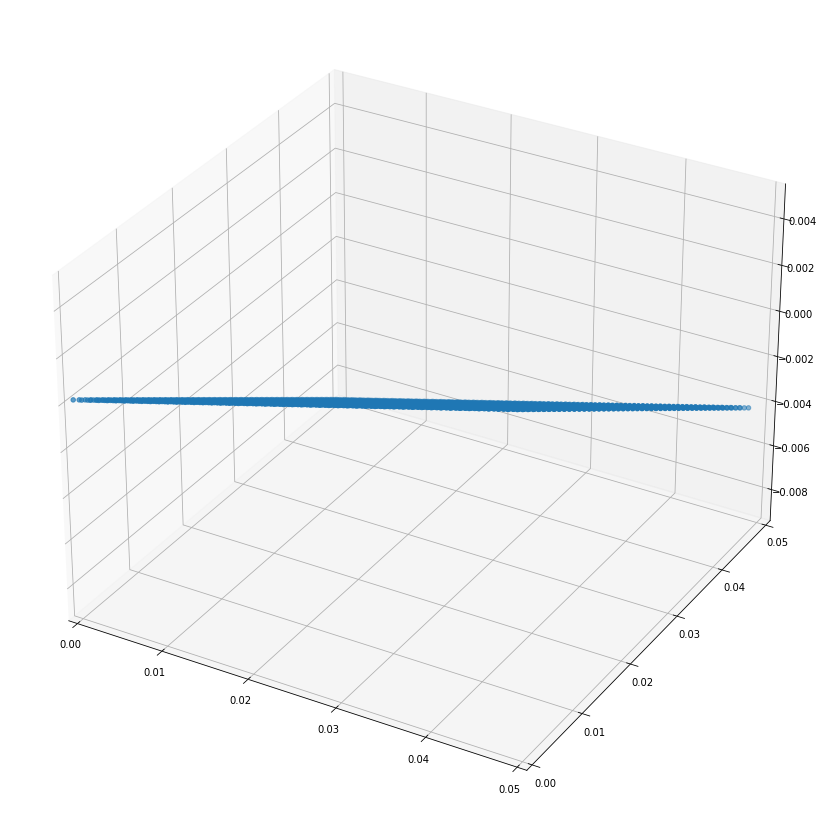

In [12]:
X = np.arange(0, 0.05, .001)
Y = np.arange(0, 0.05, .001)

features = np.zeros((len(X)*len(Y), 3))
i = 0
for Xi in X:
    for Yi in Y:
        features[i] = (0, Xi, Yi)
        i += 1
X = torch.tensor(features, dtype=torch.float32)

Y = NN(X).detach().numpy().reshape(-1,)
X = X.detach().numpy()
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')

X, Y, Z = X[:,1], X[:, 2], Y
ax.scatter(X, Y, Z)
ax.set_xlim(0, 0.05)
ax.set_ylim(0, 0.05)
ax.set_zlim(min(Z), max(Z))
plt.show()


In [4]:
kfold = TimeSeriesSplit(n_splits = 8, max_train_size = None, test_size=300, gap=25)
for idx_train, idx_test in kfold.split(data_nn_train.x_t):
    train_start, train_end = idx_train[0], idx_train[-1]
    test_start, test_end = idx_test[0], idx_test[-1]
    print(train_start, train_end, "-", test_start, test_end)


0 2782 - 2808 3107
0 3082 - 3108 3407
0 3382 - 3408 3707
0 3682 - 3708 4007
0 3982 - 4008 4307
0 4282 - 4308 4607
0 4582 - 4608 4907
0 4882 - 4908 5207
